# Santander Customer Transaction Prediction

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, confusion_matrix
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import seaborn as sns

c:\users\moutz\desktop\pythonenv\venv\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
train_df = pd.read_csv("../project/data/train_small.csv", header=None)
test_df = pd.read_csv("../project/data/test_small.csv")

train_df.columns = list([test_df.columns[0],"target",*test_df.columns[1:]])

## Data Preprocessing

In [ ]:
response = np.array(train_df['target'])
features = np.array(train_df.iloc[:,2:])
features_list = list(train_df.iloc[:,2:].columns)

from sklearn.model_selection import train_test_split
train_features, test_features, train_response, test_response = train_test_split(features, response, test_size = 0.25, random_state = 42)


In [ ]:
print("train: ", 100*train_response.sum()/train_response.size,"   test: ", 100*test_response.sum()/test_response.size)

## Feature Selection 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, random_state = 42, verbose = 10,n_jobs = -1)

rf.fit(train_features, train_response)



In [ ]:
preds = rf.predict(test_features)
pd.crosstab(test_response, preds, rownames=['Actual Value'], colnames=['Predicted Value'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Plot the feature importances of the forest
plt.figure(figsize = (20,15))
plt.title("Feature importances")
plt.bar(range(test_features.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(test_features.shape[1]), indices, rotation='vertical')
plt.xlim([-1, test_features.shape[1]])
plt.show()

In [ ]:
importances.min()

In [12]:
def plt_density(df, var):
    plt.figure(figsize = (10,10))
    sns.distplot(df.X.loc[df.y == 0,var],hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3}, 
                      label = "target = 0")
    sns.distplot(df.X.loc[df.y == 1,var],hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3}, 
                      label = "target = 1")

    plt.title('Density Plot of ' + var)
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.show()

# 3,4,7,10,11,14,15,16,17,19,20,23,25,27,29,30,31,32,37,38,39,41,42,45,46,47,50,52,54,55,57,59,60,61,63,64,65,68,69,72,73,77,79,82,83,84,85,89,90,96,97,98,100,101,102
# 103,104,105,,113,116,117,120,124,126,128,129

In [ ]:
plt_density(train_df, 'var_81')

## Hyperparameter Tuning

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.sum(errors)/test_labels.size
    accuracy = 100 - mape
    fpr, tpr, thresholds = roc_curve(test_labels, predictions)
    plt.figure(figsize = (10,10))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.show()
    decision_boundary = 0.18
    predictions[predictions < decision_boundary] = 0
    predictions[predictions >= decision_boundary] = 1
    conf_mat = confusion_matrix(test_labels, predictions)
    print('Model Performance')
    print(conf_mat)
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

## Random search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(train_features, train_response);

In [ ]:
rf_random.best_params_

In [ ]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

In [ ]:
best_params_random = joblib.load("../project/best_params_rf.pkl")
best_estimator_random= joblib.load("../project/best_estimator_rf.pkl")
best_params_random

In [ ]:
random_accuracy = evaluate(best_estimator_random, test_features, test_response)

## Grid search 1

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [20, 30, 40],
    'max_features': [2, 3],
    'min_samples_leaf': [4, 5, 6],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1800, 2000, 2200]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)
grid_search.fit(train_features, train_labels)

In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

### Grid search 2

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [110, 120, None],
    'max_features': [3, 4],
    'min_samples_leaf': [5, 6, 7],
    'min_samples_split': [10],
    'n_estimators': [75, 100, 125]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search_final = GridSearchCV(estimator = rf, param_grid = param_grid, 
                                 cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

grid_search_final.fit(train_features, train_labels);

In [ ]:
grid_search_final.best_params_

In [ ]:
best_grid_final = grid_search_final.best_estimator_
grid_final_accuracy = evaluate(best_grid_final, test_features, test_labels)

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

# Logistic Regression

Our model consists of 200 features, $x_j$ for $j\in\{1,...,200\}$, and a response $\mathbf{y}$ which has binary values $y \in \{0,1\}$. The response is assumed to follow a Bernoulli distribution s.t. $P(y=1)= p = 1-P(y=0) = 1-q$. We can then write the logarithm of the odds as follows
\begin{equation*}
ln\left(\frac{p}{1-p}\right) = \beta_0 + \beta_1\mathbf{x_1} + \dots \ \beta_{200}\mathbf{x_{200}},
\end{equation*}
which we can rewrite to
\begin{equation*}
P(y = 1) = \frac{1}{1 + \exp\{-(\beta_0 + \beta_1\mathbf{x_1} + \dots \ \beta_{200}\mathbf{x_{200}})\}} = f(\mathbf{X},\beta).
\end{equation*}
This is the logit function, which squeezes the values between zero and one. Let us now vectorize $\mathbf{\beta}$ and create the design matrix $\mathbf{X}$. We now want to find the maximum likelihood estimates of the $\mathbf{\beta}$s' assuming that the response $\mathbf {y}$ are independently Bernoulli distributed. The log-likelihood function then becomes
\begin{equation*}
l(\mathbf{\beta}|\mathbf{X}) = \sum\limits_{i=1}^{n}ln(P(y_i|\mathbf{x}_i,\mathbf{\beta})) = \sum\limits_{i=1}^n(y_i ln(f(\mathbf{x}_i,\beta) +  (1-y_i)ln(1 - f(\mathbf{x}_i,\beta)).
\end{equation*}
To find the maximum likelihood estimates of $\beta$, a numerical optimization method is used s.t.
\begin{equation*}
\hat{\beta} = \underset{\beta}{\mathrm{argmax}} \enspace l(\beta|\mathbf{X}).
\end{equation*}

In [32]:
from datasets import get_datasets
datasets = get_datasets()

In [33]:
from sklearn.linear_model import LogisticRegression
data = datasets.small.resplit(0.75,0,0.25)

In [23]:
logreg = LogisticRegression(solver='lbfgs',max_iter = 10000)
logreg.fit(data.train_split.X, data.train_split.y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
y_pred = logreg.predict_proba(data.test_split.X)

### Evaluation Report

__PRC AUC Score:__ 0.51940

__ROC AUC Score:__ 0.86421



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 91.68%

__Balanced Accuracy:__ 63.59%


__Sensitivity:__ 28.51%

__Specificity:__ 98.68%

__Class 1 Precision:__ 70.54%

__Class 1 Recall:__ 28.51%

,Condition Positive,Condition Negative
Positive Prediction,498,208
Negative Prediction,1249,15560


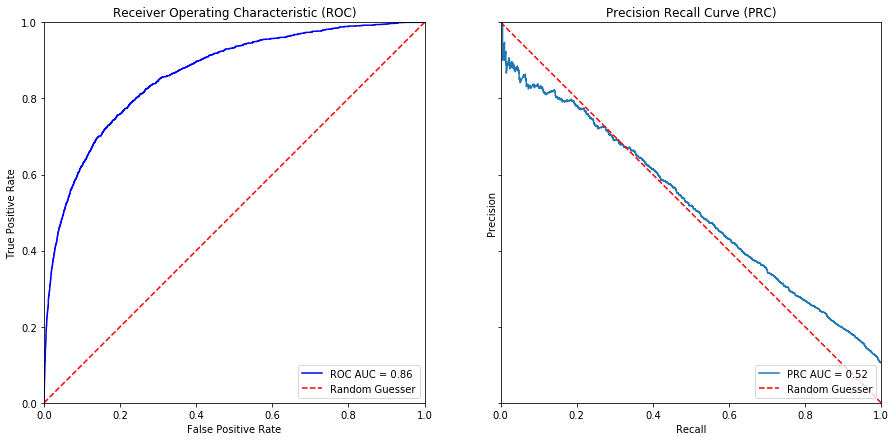

In [25]:
data.evaluate(y_pred,plot_roc = True)

## Over Sampling

In [34]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
os_features,os_response=os.fit_sample(data.train_split.X, data.train_split.y)

In [35]:
print("length of oversampled data is ",len(os_features))
print("Number of 0 labels in oversampled data",len(os_response[os_response==0]))
print("Number of 1 labels",len(os_response[os_response==1]))
print("Proportion of 0 labels in oversampled data is ",len(os_response[os_response==0])/len(os_features))
print("Proportion of 1 labels in oversampled data is ",len(os_response[os_response==1])/len(os_features))

length of oversampled data is  94604
Number of 0 labels in oversampled data 47302
Number of 1 labels 47302
Proportion of 0 labels in oversampled data is  0.5
Proportion of 1 labels in oversampled data is  0.5


In [36]:
lg_os = LogisticRegression(solver='lbfgs',max_iter = 10000)
lg_os.fit(os_features, os_response)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
y_pred = lg_os.predict_proba(data.test_split.X)

### Evaluation Report

__PRC AUC Score:__ 0.51219

__ROC AUC Score:__ 0.86071



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 78.44%

__Balanced Accuracy:__ 78.00%


__Sensitivity:__ 77.45%

__Specificity:__ 78.55%

__Class 1 Precision:__ 28.57%

__Class 1 Recall:__ 77.45%

,Condition Positive,Condition Negative
Positive Prediction,1353,3383
Negative Prediction,394,12385


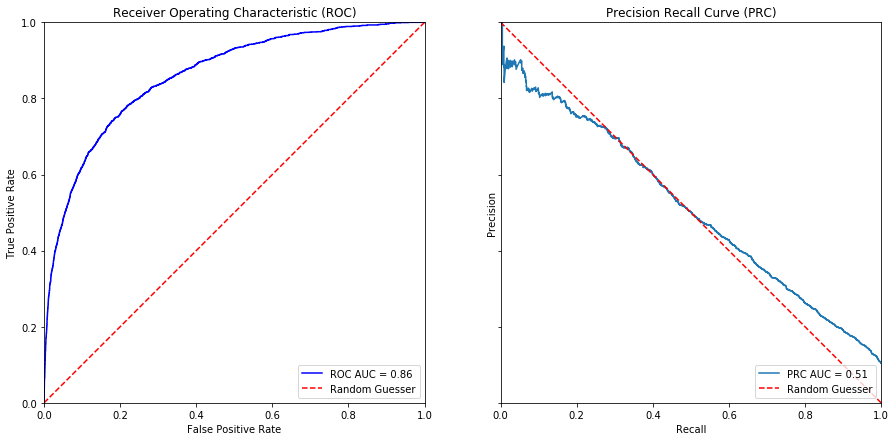

In [43]:
data.evaluate(y_pred,plot_roc = True)

## Feature Selection

In [ ]:
from sklearn.feature_selection import RFECV

lg_os = LogisticRegression(solver='lbfgs',max_iter=1000)
rfe = RFECV(logreg, min_features_to_select  = 20, step=1, cv=5, n_jobs = -1, verbose = 10)
rfe = rfe.fit(os_features, os_response)

# Naive Bayes Classifier

The naive bayes Classifier comes from Bayes theorem 
\begin{equation*}
 P(\mathbf{y}|\mathbf{X}) = \frac{P(\mathbf{X}|\mathbf{y})P(\mathbf{y})}{P(\mathbf{X})},
\end{equation*}
which means that we can find the probability for classification $\mathbf{y}$ based on the features $\mathbf{X}$. The naive part of this classifier is the assumptions that the features are independent i.e. $P(\mathbf{x}_i,\mathbf{x}_j) = P(\mathbf{x}_i)P(\mathbf{x}_j)$.
The features are contained in the vector $\mathbf{X} = (\mathbf{x}_1, \mathbf{x}_2,\dots,\mathbf{x}_{200})$ and thereby we can rewrite bayes theorem to 
\begin{equation*}
 P(\mathbf{y}|\mathbf{X}) = \frac{P(\mathbf{x}_1|\mathbf{y})P(\mathbf{x}_2|\mathbf{y})\dots P(\mathbf{x}_{200}|\mathbf{y})P(\mathbf{y})}{P(\mathbf{x}_1)P(\mathbf{x}_2)\dots P(\mathbf{x}_{200})}.
\end{equation*}
The denominator in this is constant and we can rewrite the expression to
\begin{equation*}
P(\mathbf{y}|\mathbf{X}) \propto P(\mathbf{y}) \prod\limits_{i = 1}^{200} P(\mathbf{x}_i|\mathbf{y}),
\end{equation*}
thereby yielding the classifier 
\begin{equation*}
    y = \underset{y}{\mathrm{argmax}} P(y) \prod\limits_{i = 1}^{200} P(\mathbf{x}_i|y).
\end{equation*}

Furthermore we need to define the prior $P(y)$ and the likelihood $P(\mathbf{X}_i|y)$. Our prior belief about $y$ would be the distribution of class $1$ or $0$ labels, which is yields the bernoulli distribution $P(y = 1) \approx 0.1$ and $P(y = 0) \approx 0.9$. 
The choice of likelihood functions is done by looking at the distributions of $\mathbf{X}_i|y = j$. Below we import the dataset with a train/test = $0.9/0.1$, and then we visualize the distribution of 'var_3'.

In [ ]:
from datasets import get_datasets
datasets = get_datasets()

In [ ]:
from sklearn.naive_bayes import GaussianNB
data = datasets.small.resplit(0.75,0,0.25)

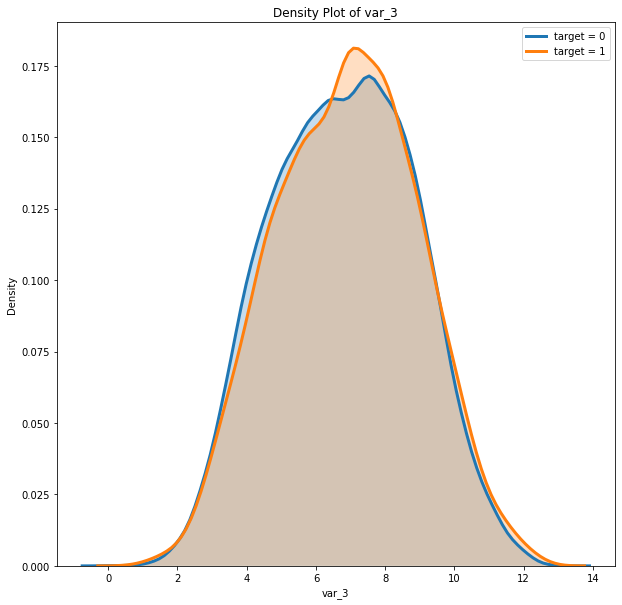

In [37]:
plt_density(data.train_split, 'var_3')

As seen see the the distribution above  is has some similarities with the Gaussian distribution. This is not true for all featues, however we make this assumption and set the likelihood to follow the Gaussian distribution given by the equation 
\begin{equation*}
    x_i|y=j \sim \frac{1}{\sqrt{2\pi\sigma_y^2}}\exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma_y^2}\right),
\end{equation*}
where $\mu_y = E(x_i|y = j)$ and $\sigma_y^2 = Var(x_i|y = j)$. If you were to manually program this it would be to take the column mean and standard deviation given the target value $y = j$ where $j \in \{0,1\}$. Thereby using these as the parameters in the distribution of the likelihood.

In [38]:
data.summary()

### DataSet summary

__Train size:__ 70057 __Class balance:__ 90.03% / 10.0%

#### Sub-splits

__Train, validation, test split__ = (0.75, 0, 0.25)

__Train split size:__ 52542 __Class balance:__ 90.03% / 10.0%

__Test split size:__ 17515 __Class balance:__ 90.03% / 10.0%

In [39]:
gnb = GaussianNB()
gnb_model = gnb.fit(data.train_split.X, data.train_split.y)

In [40]:
y_pred = gnb_model.predict_proba(data.test_split.X)

### Evaluation Report

__PRC AUC Score:__ 0.59541

__ROC AUC Score:__ 0.89251



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 92.41%

__Balanced Accuracy:__ 68.02%


__Sensitivity:__ 37.55%

__Specificity:__ 98.48%

__Class 1 Precision:__ 73.30%

__Class 1 Recall:__ 37.55%

,Condition Positive,Condition Negative
Positive Prediction,656,239
Negative Prediction,1091,15529


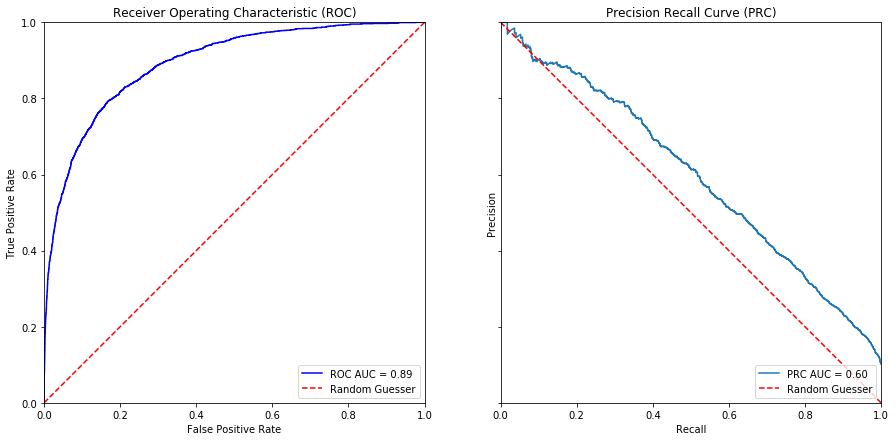

In [41]:
data.evaluate(y_pred[:,1],plot_roc = True)

## Oversampling

In [18]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
os_features,os_response=os.fit_sample(data.train_split.X, data.train_split.y)
print("length of oversampled data is ",len(os_features))
print("Number of 0 labels in oversampled data",len(os_response[os_response==0]))
print("Number of 1 labels",len(os_response[os_response==1]))
print("Proportion of 0 labels in oversampled data is ",len(os_response[os_response==0])/len(os_features))
print("Proportion of 1 labels in oversampled data is ",len(os_response[os_response==1])/len(os_features))

Using TensorFlow backend.


length of oversampled data is  94604
Number of 0 labels in oversampled data 47302
Number of 1 labels 47302
Proportion of 0 labels in oversampled data is  0.5
Proportion of 1 labels in oversampled data is  0.5


In [19]:
gnb_os = GaussianNB()
gnb_model_os = gnb_os.fit(os_features, os_response)

In [20]:
y_pred = gnb_model_os.predict_proba(data.test_split.X)

### Evaluation Report

__PRC AUC Score:__ 0.12831

__ROC AUC Score:__ 0.57966



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 87.12%

__Balanced Accuracy:__ 51.62%


__Sensitivity:__ 7.27%

__Specificity:__ 95.97%

__Class 1 Precision:__ 16.64%

__Class 1 Recall:__ 7.27%

,Condition Positive,Condition Negative
Positive Prediction,127,636
Negative Prediction,1620,15132


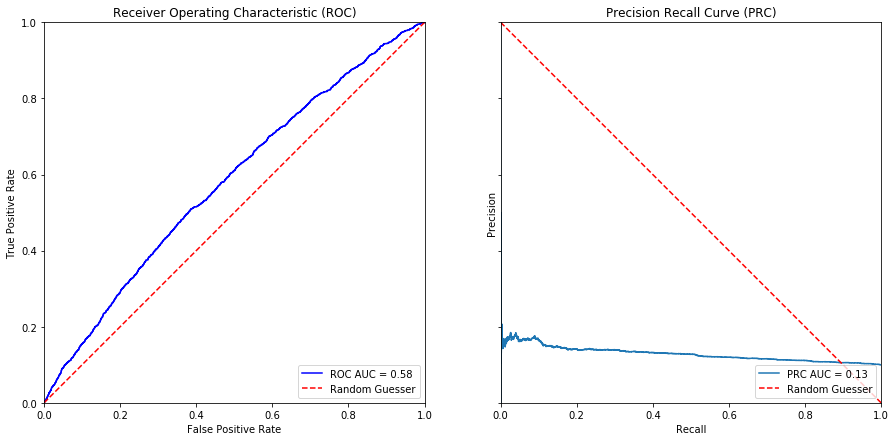

In [21]:
data.evaluate(y_pred[:,1],plot_roc = True)

# xgboost

In [ ]:
import xgboost as xgb
data = datasets.small.resplit(0.75,0,0.25)
dtrain = xgb.DMatrix(data.train_split.X,data.train_split.y)
dtest = xgb.DMatrix(data.test_split.X,data.test_split.y)
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'binary:logistic',
}
params['eval_metric'] = "auc"
num_boost_round = 999

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)


## Ensamble

In [66]:
y_pred_lr = lg_os.predict_proba(data.train_split.X)
y_pred_nb = gnb.predict_proba(data.train_split.X)
y_pred = np.concatenate([y_pred_lr, y_pred_nb],axis = 1)

In [67]:
y_pred.shape

(52542, 4)

In [2]:
from sklearn.linear_model import LinearRegression

In [74]:
regressor = LinearRegressor()

In [78]:
regressor.fit(y_pred, data.train_split.y) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [81]:
regressor.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [36]:
y_test_pred = regressor.predict(np.concatenate([
    lg_os.predict_proba(data.test_split.X),
    gnb.predict_proba(data.test_split.X)
],axis=1))

### Evaluation Report

__PRC AUC Score:__ 0.62081

__ROC AUC Score:__ 0.89798



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 92.66%

__Balanced Accuracy:__ 68.40%


__Sensitivity:__ 38.11%

__Specificity:__ 98.70%

__Class 1 Precision:__ 76.44%

__Class 1 Recall:__ 38.11%

,Condition Positive,Condition Negative
Positive Prediction,133,41
Negative Prediction,216,3113


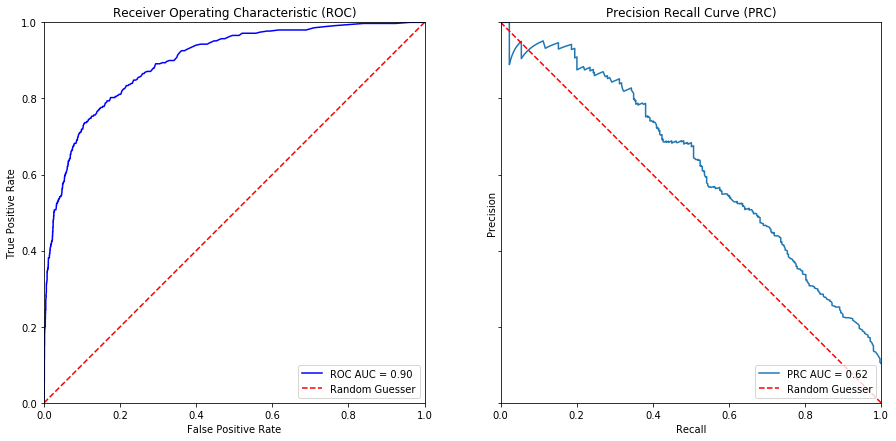

In [37]:
data.evaluate(y_test_pred,plot_roc = True)

### Predict on overall testset

In [3]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [6]:
from datasets import get_datasets
datasets = get_datasets()
data = datasets.small.resplit(0.95,0,0.05)

In [7]:
os = SMOTE(random_state=0)
os_features,os_response=os.fit_sample(data.train_split.X, data.train_split.y)

In [8]:
regressor = LinearRegression()
gnb = GaussianNB()
lg_os = LogisticRegression(solver='lbfgs',max_iter = 10000)

In [9]:
gnb.fit(data.train_split.X,data.train_split.y)
lg_os.fit(os_features,os_response)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
y_pred_lr = lg_os.predict_proba(data.train_split.X)
y_pred_nb = gnb.predict_proba(data.train_split.X)
y_pred = np.concatenate([y_pred_lr, y_pred_nb],axis = 1)

In [11]:
regressor.fit(y_pred, data.train_split.y) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
test_small_x = pd.read_csv("../project/data/test_small.csv")

In [19]:
test_x = np.array(test_small_x.iloc[:,1:])

In [20]:
y_test_pred = regressor.predict(np.concatenate([
    lg_os.predict_proba(test_x),
    gnb.predict_proba(test_x)
],axis=1))

In [27]:
test_small_x

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
2,train_7,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,5.0647,...,13.1700,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806
3,train_12,8.7671,-4.6154,9.7242,7.4242,9.0254,1.4247,6.2815,12.3143,5.6964,...,0.3782,7.4382,0.0854,1.3444,17.2439,-0.0798,5.7389,8.4897,17.0938,4.6106
4,train_14,13.8080,5.0514,17.2611,8.5120,12.8517,-9.1622,5.7327,21.0517,-4.5117,...,1.0740,8.3220,3.2619,1.6738,17.4797,-0.0257,-3.5323,9.3439,24.4479,-5.1110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70060,train_199973,8.7758,-0.4604,8.0874,6.4538,13.0035,0.1872,4.3495,20.0410,3.8901,...,4.5471,6.8276,2.5206,9.2046,19.5153,-1.2611,7.6877,8.2211,16.1504,22.6103
70061,train_199978,12.2015,-0.8787,16.8069,9.1073,10.3219,7.0208,6.2587,19.8344,4.9897,...,-0.8481,5.5487,2.0673,-5.6931,16.5850,-1.9920,3.1963,7.5484,13.1150,6.7866
70062,train_199979,10.8208,-2.9344,15.0906,9.7810,9.4014,-4.5704,5.3201,16.0858,2.1450,...,5.4512,10.1153,0.1237,3.1777,20.9673,-1.5221,6.5048,9.5072,17.3854,-4.0844
70063,train_199985,9.0249,-3.6379,12.3907,5.1915,12.1701,-8.8978,5.2574,17.9830,3.2907,...,7.8321,5.3869,1.4127,9.5404,12.3053,2.5935,8.0172,8.1901,18.5124,-15.6321


In [30]:
sample_sub = pd.DataFrame(np.array([test_small_x.iloc[:,0],y_test_pred]).transpose(),columns=["ID_code","target"])

In [31]:
sample_sub

,ID_code,target
0,train_0,0.0117188
1,train_3,0.209961
2,train_7,0.0390625
3,train_12,0.0371094
4,train_14,0.0976562
...,...,...
70060,train_199973,0.0185547
70061,train_199978,0.0390625
70062,train_199979,0.446289
70063,train_199985,0.015625


In [33]:
sample_sub.to_csv("../project/test_pred.csv")

## max_depth and min_child_weigth

In [167]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [ ]:
# Define initial best params and MAE
min_auc = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_auc= cv_results['test-auc-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].idxmin()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc < min_auc:
        min_auc = mean_auc
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], min_auc))

In [ ]:
params['max_depth'] = 10
params['min_child_weight'] = 6

## Subsample and colsample

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [ ]:
min_auc = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_auc = cv_results['test-auc-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].argmin()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc < min_auc:
        min_auc = mean_auc
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_auc))

In [ ]:
params['subsample'] = .8
params['colsample_bytree'] = 1.

## Learning rate

In [ ]:
min_auc = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['auc'],
            early_stopping_rounds=10
          )
    # Update best score
    mean_auc = cv_results['test-auc-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].argmin()
    print("\tAUC {} for {} rounds\n".format(mean_auc, boost_rounds))
    if mean_auc < min_auc:
        min_auc= mean_auc
        best_params = eta
print("Best params: {}, AUC: {}".format(best_params, min_auc))

In [ ]:
params['eta'] = .01

## Results

In [ ]:

params = {
    'colsample_bylevel': 0.18273244758535206,
    'colsample_bytree': 0.7530295101748936,
    'gamma': 0.2941753333970994,
    'max_delta_step': 19,
    'max_depth': 7,
    'subsample': 0.8,
    'eval_metric': 'auc',
    'reg_alpha': 0.118691638938,
    'min_child_weight': 2,
    'colsample_bytree': 1.0,
    'objective':'binary:logistic'
}

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

In [ ]:
model2 = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10,
    xgb_model=model
)

In [ ]:
y_pred = model2.predict(dtest)
data.evaluate(y_pred,plot_roc = True)

# NN

## Model

In [157]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def build_model():
    model = Sequential()
    model.add(Dense(256, input_shape = (200,)))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1024))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(2048))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(2048))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(2048))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(2048))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(2048))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1024))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])
    return(model)

In [158]:
tf.keras.backend.clear_session()
model = build_model()
tf.keras.backend.clear_session()
model2 = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               51456     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0

## Data prepo

In [53]:
from datasets import get_datasets
datasets = get_datasets()

In [150]:
data = datasets.small.resplit(0.7,0.15,0.15)

In [151]:
data2 = datasets.small.resplit(0.7,0.15,0.15)
os = SMOTE(random_state=0)
os_features_train, os_response_train = os.fit_sample(data2.train_split.X, data2.train_split.y)
os_features_val, os_response_val = os.fit_sample(data2.val_split.X, data2.val_split.y)
from datasets import xy
data2.train_split = xy(X = os_features_train, y = os_response_train)
data2.val_split = xy(X = os_features_val, y = os_response_val)

In [152]:
data2.summary()

### DataSet summary

__Train size:__ 70057 __Class balance:__ 90.03% / 10.0%

#### Sub-splits

__Train, validation, test split__ = (0.7, 0.15, 0.15)

__Train split size:__ 88296 __Class balance:__ 50.00% / 50.0%

__Validation split size:__ 18922 __Class balance:__ 50.00% / 50.0%

__Test split size:__ 10509 __Class balance:__ 90.03% / 10.0%

In [153]:
x_train = data.train_split.X.to_numpy()
y_train = data.train_split.y.to_numpy()
x_valid = data.val_split.X.to_numpy()
y_valid = data.val_split.y.to_numpy()
x_test = data.test_split.X.to_numpy()
y_test = data.test_split.y.to_numpy()
x_train2 = data2.train_split.X
y_train2 = data2.train_split.y
x_val2 = data2.val_split.X
y_val2 = data2.val_split.y

In [105]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)

In [154]:
callbacks = [
    EarlyStopping(monitor='val_auc', patience=3, mode = 'max'),
    ModelCheckpoint(filepath='../project/models/best_val_weights1.h5', save_best_only=True, monitor='val_auc', verbose=1, mode = 'max'),
    ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=1, min_lr=0.001, mode = 'max',verbose = 1)
]
callbacks2 = [
    EarlyStopping(monitor='val_auc', patience=3, mode = 'max'),
    ModelCheckpoint(filepath='../project/models/best_val_weights2.h5', save_best_only=True, monitor='val_auc', verbose=1, mode = 'max'),
    ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=1, min_lr=0.001, mode = 'max',verbose = 1)
]

## Fit

In [159]:
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data = (x_valid, y_valid),
                    callbacks = callbacks
)

Train on 49039 samples, validate on 10509 samples
Epoch 1/50
49024/49039 [============================>.] - ETA: 0s - loss: 0.2962 - auc: 0.7262
Epoch 00001: val_auc did not improve from 0.84106
49039/49039 [==============================] - 126s 3ms/sample - loss: 0.2961 - auc: 0.7262 - val_loss: 0.2523 - val_auc: 0.8305
Epoch 2/50
49024/49039 [============================>.] - ETA: 0s - loss: 0.2632 - auc: 0.8062
Epoch 00002: val_auc did not improve from 0.84106
49039/49039 [==============================] - 128s 3ms/sample - loss: 0.2632 - auc: 0.8063 - val_loss: 0.2467 - val_auc: 0.8347
Epoch 3/50
49024/49039 [============================>.] - ETA: 0s - loss: 0.2523 - auc: 0.8278
Epoch 00003: val_auc did not improve from 0.84106
49039/49039 [==============================] - 127s 3ms/sample - loss: 0.2523 - auc: 0.8277 - val_loss: 0.2444 - val_auc: 0.8355
Epoch 4/50
49024/49039 [============================>.] - ETA: 0s - loss: 0.2486 - auc: 0.8354
Epoch 00004: val_auc improved fro

In [160]:
history2 = model2.fit(x_train2, y_train2,
                    batch_size=32,
                    epochs=50,
                    validation_data = (x_val2, y_val2),
                    callbacks = callbacks2
)

Train on 88296 samples, validate on 18922 samples
Epoch 1/50
88288/88296 [============================>.] - ETA: 0s - loss: 0.4019 - auc: 0.8993
Epoch 00001: val_auc improved from 0.88462 to 0.91672, saving model to ../project/models/best_val_weights2.h5
88296/88296 [==============================] - 258s 3ms/sample - loss: 0.4018 - auc: 0.8993 - val_loss: 0.3692 - val_auc: 0.9167
Epoch 2/50
88288/88296 [============================>.] - ETA: 0s - loss: 0.3144 - auc: 0.9393
Epoch 00002: val_auc did not improve from 0.91672

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.001.
88296/88296 [==============================] - 234s 3ms/sample - loss: 0.3144 - auc: 0.9393 - val_loss: 0.3735 - val_auc: 0.9160
Epoch 3/50
88288/88296 [============================>.] - ETA: 0s - loss: 0.2780 - auc: 0.9526
Epoch 00003: val_auc improved from 0.91672 to 0.91680, saving model to ../project/models/best_val_weights2.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.001.
88296/8

In [161]:
model.load_weights("../project/models/best_val_weights1.h5")
model2.load_weights("../project/models/best_val_weights2.h5")

In [162]:
y_pred1 = model.predict(x_test)
y_pred2 = model2.predict(x_test)

### Evaluation Report

__PRC AUC Score:__ 0.47715

__ROC AUC Score:__ 0.84832



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 91.26%

__Balanced Accuracy:__ 61.63%


__Sensitivity:__ 24.62%

__Specificity:__ 98.64%

__Class 1 Precision:__ 66.67%

__Class 1 Recall:__ 24.62%

,Condition Positive,Condition Negative
Positive Prediction,258,129
Negative Prediction,790,9332


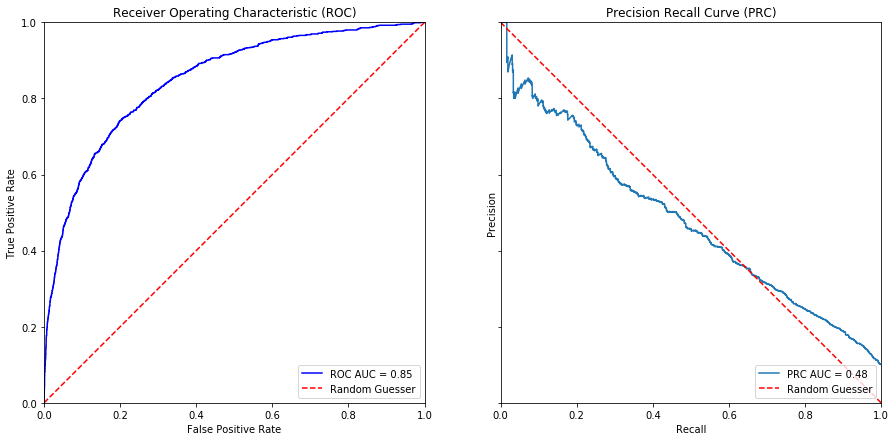

In [163]:
data.evaluate(y_pred1[:,0],plot_roc = True)

### Evaluation Report

__PRC AUC Score:__ 0.28202

__ROC AUC Score:__ 0.76694



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 85.56%

__Balanced Accuracy:__ 63.26%


__Sensitivity:__ 35.40%

__Specificity:__ 91.11%

__Class 1 Precision:__ 30.61%

__Class 1 Recall:__ 35.40%

,Condition Positive,Condition Negative
Positive Prediction,371,841
Negative Prediction,677,8620


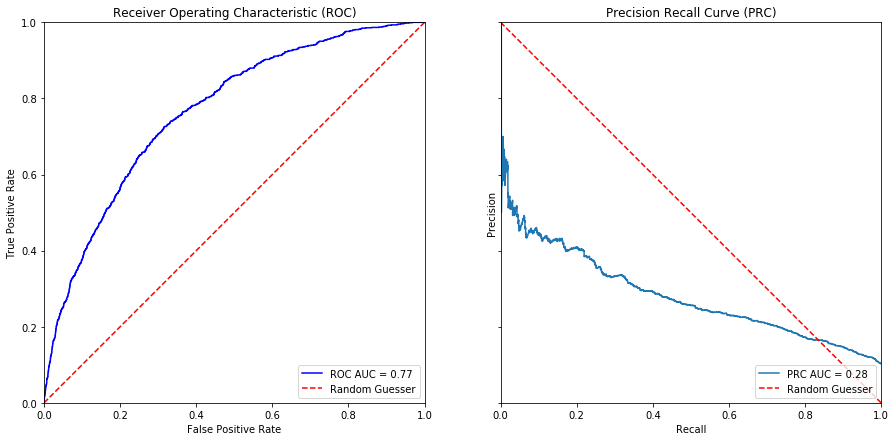

In [164]:
data.evaluate(y_pred2[:,0],plot_roc = True)

## Bayesian Search CV

In [15]:
import pandas as pd, numpy as np
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

def objective(space):

    clf = xgb.XGBClassifier(n_estimators = 10000,
                            max_depth = space['max_depth'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'])

    eval_set  = [( train, y_train), ( valid, y_valid)]

    clf.fit(train[col_train], y_train,
            eval_set=eval_set, eval_metric="auc",
            early_stopping_rounds=30)

    pred = clf.predict_proba(valid)[:,1]
    auc = roc_auc_score(y_valid, pred)
    print("SCORE:", auc)

    return{'loss':1-auc, 'status': STATUS_OK }

space ={
        'max_depth': hp.quniform("x_max_depth", 5, 30, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1)
    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)

--------------------------------------------------------------------------------                                                                                                    
CANT ENCODE                                                                                                                                                                         
--------------------------------------------------------------------------------                                                                                                    
  0%|                                                                                                                                         | 0/100 [00:00<?, ?it/s, best loss: ?]


AttributeError: module 'bson' has no attribute 'BSON'

In [5]:
BayesianOptimization

Init signature: BayesianOptimization(f, pbounds, random_state=None, verbose=2)
Docstring:     
Inspired/Taken from
    https://www.protechtraining.com/blog/post/879#simple-observer
File:           c:\users\moutz\desktop\pythonenv\venv\lib\site-packages\bayes_opt\bayesian_optimization.py
Type:           type
Subclasses:     
